In [14]:
import pandas as pd
from ensemble import StdForestClassifier
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.ensemble import RandomForestClassifier
import shap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/train_transaction.csv')

In [33]:
df.index = list(df[df['isFraud'] ==0].sample(frac=0.1).index) + list(df[df['isFraud'] ==1].index)

ValueError: Length mismatch: Expected axis has 59054 elements, new values have 7770 elements

Int64Index([494221, 196974, 316271, 461224, 191704, 550792, 282990, 276473,
            404913, 219320,
            ...
            544005, 498765, 292682, 318749,  91358,  76339, 413528, 580597,
            437542,  52776],
           dtype='int64', length=2072)

In [3]:
df = df.iloc[:, :-300]
df = df.sample(frac=0.1)

In [4]:
X = df.drop(columns=['TransactionID', 'isFraud', 'TransactionDT'])
y = df[['isFraud']]

In [5]:
X = X.fillna(-1)

In [6]:
X = MEstimateEncoder().fit_transform(X,y)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [7]:
X_tr, X_te, y_tr, y_te = train_test_split(X,y,stratify=y,test_size=0.1)

In [8]:
rf = RandomForestClassifier(n_estimators= 10)

In [13]:
roc_auc_score(rf.predict(X_te),y_te)

0.9067348952969447

In [9]:
%%time
rf.fit(X_tr,y_tr)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 933 ms, sys: 33.2 ms, total: 966 ms
Wall time: 1.36 s


RandomForestClassifier(n_estimators=10)

In [16]:
print(classification_report(rf.predict(X_te),y_te))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5826
           1       0.32      0.84      0.47        80

    accuracy                           0.97      5906
   macro avg       0.66      0.91      0.73      5906
weighted avg       0.99      0.97      0.98      5906



Feature ranking:
1. feature 0 (0.065066)
2. feature 2 (0.049173)
3. feature 14 (0.044554)
4. feature 3 (0.042994)
5. feature 8 (0.036205)
6. feature 25 (0.034487)
7. feature 26 (0.033988)
8. feature 27 (0.028740)
9. feature 15 (0.027692)
10. feature 29 (0.027103)
11. feature 12 (0.025812)
12. feature 6 (0.023767)
13. feature 24 (0.023660)
14. feature 13 (0.023255)
15. feature 17 (0.022989)
16. feature 28 (0.022987)
17. feature 20 (0.021437)
18. feature 35 (0.019597)
19. feature 42 (0.019449)
20. feature 30 (0.017756)
21. feature 19 (0.017460)
22. feature 37 (0.016687)
23. feature 31 (0.015703)
24. feature 32 (0.014110)
25. feature 21 (0.013460)
26. feature 5 (0.012766)
27. feature 36 (0.012744)
28. feature 10 (0.012567)
29. feature 38 (0.011464)
30. feature 89 (0.011464)
31. feature 7 (0.010880)
32. feature 23 (0.010518)
33. feature 11 (0.010111)
34. feature 41 (0.009621)
35. feature 22 (0.008970)
36. feature 75 (0.008524)
37. feature 4 (0.008167)
38. feature 46 (0.007786)
39. feature 

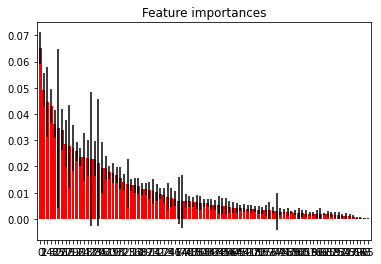

In [10]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()